In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform= transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

batch_size=16

train_dataset= torchvision.datasets.SVHN(root='./data', download=True,
                                   split='train',
                                  transform=transform)
val_dataset= torchvision.datasets.SVHN(root='./data', download=True,
                                   split='test',
                                  transform=transform)
test_dataset= torchvision.datasets.SVHN(root='./data', download=True,
                                   split='extra',
                                  transform=transform)

train_dataset_length = len(train_dataset)
val_dataset_length = len(val_dataset)
test_dataset_length = len(test_dataset)
print(f'train dataset length : {train_dataset_length}')
print(f'validation dataset length : {val_dataset_length}')
print(f'test dataset length : {test_dataset_length}')



Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/extra_32x32.mat
train dataset length : 73257
validation dataset length : 26032
test dataset length : 531131


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,
                                          batch_size=batch_size,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,
                                          batch_size=batch_size,num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True,
                                          batch_size=batch_size,num_workers=4)

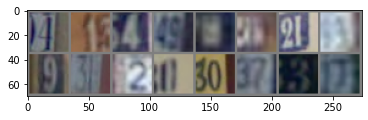

tensor([4, 1, 4, 9, 9, 8, 1, 3, 9, 1, 2, 0, 0, 7, 3, 7])
torch.Size([16, 3, 32, 32])


In [5]:
def pltimage(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
    #plt.imshow(img.squeeze(),cmap='gray')
    plt.show()
    
dataiter= iter(train_loader)
images,labels= dataiter.next()
pltimage(images)

print(labels)

print(images.shape)


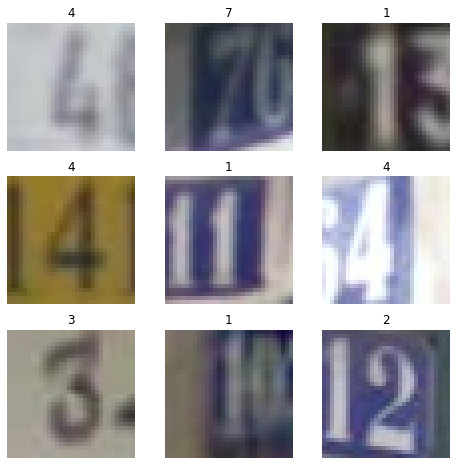

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    img = img / 2 + 0.5
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
    #plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [7]:
class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,18,5)
        self.pool = nn.AvgPool2d(2,2)
        self.fc1 = nn.Linear(5*5*18,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x
        
cnn = Cnn()
cnn.to(device)

Cnn(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=450, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [8]:
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
def train(dataloader):
    total_loss = 0
    n_batches=0
    for batch,data in enumerate(dataloader):
        image,label = data[0].to(device),data[1].to(device)
        out = cnn(image)
        loss = criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        n_batches+=1
    return total_loss/n_batches
#print(iter(train_loader).next())

In [10]:
@torch.no_grad()
def test(dataloader):
    test_loss = 0
    n_batches = 0
    for images,labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        out = cnn(images)
        loss = criterion(out,labels)
        test_loss+=loss.item()
        n_batches+=1
    return test_loss/n_batches

In [11]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train(train_loader)
    val_loss = test(val_loader)
    print(f'epoch: {epoch+1} , training loss : {train_loss} , validation loss : {val_loss}')

epoch: 1 , training loss : 2.2905444906746673 , validation loss : 2.2836269297772707
epoch: 2 , training loss : 2.2791384574913462 , validation loss : 2.2472096498421386
epoch: 3 , training loss : 1.5639744308232273 , validation loss : 1.0698286439552582
epoch: 4 , training loss : 0.7674787759237426 , validation loss : 0.7752024268716592
epoch: 5 , training loss : 0.5740129820991093 , validation loss : 0.6310414210529729
epoch: 6 , training loss : 0.48320081747285687 , validation loss : 0.5333653970380539
epoch: 7 , training loss : 0.43057864409250857 , validation loss : 0.5213493592853955
epoch: 8 , training loss : 0.3907403035403001 , validation loss : 0.49507232746206675
epoch: 9 , training loss : 0.3614376594273235 , validation loss : 0.4835022885933949
epoch: 10 , training loss : 0.3374269322815979 , validation loss : 0.4734564380561126
epoch: 11 , training loss : 0.316016872041202 , validation loss : 0.46214186389127443
epoch: 12 , training loss : 0.2978140586831748 , validation 

In [12]:
with torch.no_grad():
    n_batches = 0
    total_loss = 0
    correct = 0
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        out = cnn(images)
        correct += (out.argmax(1)==labels).sum().item()
        n_batches += 1
        loss = criterion(out,labels)
        total_loss += loss.item()
    print( "final loss on test data : ",total_loss/n_batches)
    print(f"{correct} images matched correctly out of {test_dataset_length} images in the test data")
    print("accuracy on test data : ", f'{correct*100/test_dataset_length: .4f}')

final loss on test data :  0.25413063246298684
494927 images matched correctly out of 531131 images in the test data
accuracy on test data :   93.1836


radom input : 


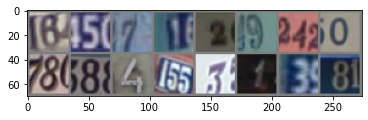

Predicted values :  [6, 5, 7, 1, 2, 9, 4, 0, 8, 8, 4, 5, 3, 1, 3, 8]
actual values    :  [6, 5, 7, 1, 2, 9, 4, 0, 8, 8, 4, 5, 3, 1, 3, 8]


In [13]:
with torch.no_grad():
    images , labels = iter(test_loader).next()
    print("radom input : ")
    pltimage(images)
    images = images.to(device)
    pred = cnn(images)
    print("Predicted values : ",pred.argmax(1).tolist())
    print("actual values    : ", labels.tolist())